<p style="font-family:consolas; font-size: 28px; color: magenta">Preprocessing the Audio Dataset</p>

In [ ]:
'''
 Audio preprocessing is a critical step in the pipeline of audio data analysis and machine learning applications. 
 It involves a series of techniques applied to raw audio data to enhance its quality, extract meaningful features, 
 and prepare it for further analysis or input into machine learning models
'''

'\n CIFAR-10 Dataset as it suggests has 10 different categories of images in it. \n There is a total of 60000 images of 10 different classes \n naming Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck. All the images are of size 32x32. \n There are in total 50000 train images and 10000 test images.\n'

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 1: _Noise Reduction:</p>


<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 2: _Standardization of Formats: </p>

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 3: _Feature Extraction: </p>

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 4: _Resampling:</p>

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 5: _Normalization:</p>

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 6: _Handling Variable Lengths: </p>

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 7: _Model Efficiency:</p>

<p style="font-family:consolas; font-size: 18px; color: orange; text-decoration-line: overline; "> 8: _Improved Model Performance: </p>


<p style="font-family:Roboto; font-size: 22px; color: magenta; text-decoration-line: overline; "> Part: _Importing required libraries</p>

In [1]:
import librosa
from scipy.signal import butter, filtfilt
import numpy as np
import os
import matplotlib.pyplot as plt 

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Load dataset</p>

In [2]:
'''
Resampling is the process of changing the sample rate of an audio signal. 
'''
# Load a sample audio file
sample_audio_path = '../data/barbie_vs_puppy/barbie/barbie_4.wav'

# Resample the audio
def resample_audio(audio_path, target_sr=16000):
    y, sr = librosa.load(audio_path, sr=target_sr)
    return y, sr
resampled_audio, sr = resample_audio(sample_audio_path)
print(f"Sample rate after Resampling: {sr}")

Sample rate after Resampling: 16000


In [ ]:
'''
So, we have resampled one audio file of the dataset to our desired sampling rate. 
We can now just iterate the dataset to resample all the files
'''

<p style="font-family:Roboto; font-size: 22px; color: magenta; text-decoration-line: overline; "> Part: _Filtering</p>

In [3]:
'''
Filtering which typically involves the application of signal processing filters like low-pass, 
high-pass or band-pass filters

'''
# Apply filtering
def butter_lowpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    print(f"Filtered audio shape: {filtered_data.shape}")
    return filtered_data

filtered_audio = butter_lowpass_filter(resampled_audio, cutoff_freq=4000, sample_rate=sr)

Filtered audio shape: (31403,)


<p style="font-family:Roboto; font-size: 22px; color: magenta; text-decoration-line: overline; "> Part: _Converting audio data to model's expected input</p>

In [ ]:
'''
Converting audio data to the model's expected input involves shaping the raw audio signal into a format 
suitable for feeding into a machine learning model
'''

In [4]:
'''
Here we will define a small function (convert_to_model_input) by which we will trim the audio files 
to a fixed target length which is here 16000 
as it is most general input shape for model feeding
'''
# Convert audio data to the model’s expected input
def convert_to_model_input(y, target_length):
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]
    return y

model_input = convert_to_model_input(filtered_audio, target_length=16000)
print(f"Model input shape: {model_input.shape}")

Model input shape: (16000,)


<p style="font-family:Roboto; font-size: 22px; color: magenta; text-decoration-line: overline; "> Part: _Audio Data Streaming</p>

In [ ]:
'''
Audio data streaming which is a process of handling and processing audio data in a sequential, batched or real-time manner
'''

In [5]:
'''The generator function stream_audio_dataset loads and processes the audio files from a specified dataset path.

#the audio_files is a list containing the path of all audios in the specified dataset.
#the list of audio file paths is shuffled to introduce randomness.
#In the batch processing step,
    $the function yields batches of audio data with a specified batch size.
    $for each batch, the code loads and preprocesses each audio file in the batch.
    $audio files are loaded using Librosa, and resampling is applied if a target sampling rate is mentioned.
    $low pass filter is applied to each audio file.
#The generator processes the batches of audio data from the specified dataset path.
#Each batch is printed with the shape of the first file in the batch.'''
def stream_audio_dataset(dataset_path, batch_size=32, target_length=16000, target_sr=None):
    # Get all audio file paths in the dataset path
    audio_files = [os.path.join(root, file) for root, dirs, files in os.walk(dataset_path) for file in files]

    # Shuffle the audio files for randomness
    np.random.shuffle(audio_files)

    # Yield batches of audio data
    for i in range(0, len(audio_files), batch_size):
        batch_paths = audio_files[i:i + batch_size]
        batch_data = []

        for file_path in batch_paths:
            # Load and preprocess each audio file
            y, sr = librosa.load(file_path, sr=target_sr)

            # Resampling
            if target_sr is not None and sr != target_sr:
                y = librosa.resample(y, sr, target_sr)
                sr = target_sr

            filtered_audio = butter_lowpass_filter(y, cutoff_freq=4000, sample_rate=sr)
            model_input = convert_to_model_input(filtered_audio, target_length=target_length)
            batch_data.append(model_input)

        yield np.array(batch_data)

# Load the dataset folder
dataset_path = '../data/barbie_vs_puppy/barbie'

for batch_data in stream_audio_dataset(dataset_path, batch_size=2, target_sr=16000):
    # Process each batch of audio data
    print(f"Processing batch with {len(batch_data)} files")

    # Print the shape of the first file in the batch
    print(f"Shape of the first file: {batch_data[0].shape}")

Filtered audio shape: (27021,)
Filtered audio shape: (36088,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (33792,)
Filtered audio shape: (37547,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (30379,)
Filtered audio shape: (40278,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (31360,)
Filtered audio shape: (33792,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (36178,)
Filtered audio shape: (31137,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (44715,)
Filtered audio shape: (37547,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (23520,)
Filtered audio shape: (31403,)
Processing batch with 2 files
Shape of the first file: (16000,)
Filtered audio shape: (28480,)
Filtered audio shape: (23520,)
Processing batch with 2 files
Shape of the first file: (

<p style="font-family:Roboto; font-size: 22px; color: magenta; text-decoration-line: overline; "> Part: _Log-Mel Spectrogram</p>

In [ ]:
'''
A log-mel spectrogram is a representation of the frequency content of an audio signal over time, 
widely used in audio signal processing and machine learning applications
'''
'''
The log-mel spectrogram further enhances visualization by taking the logarithm of the power values which makes 
it more suitable for human perception and aiding in the extraction of meaningful features.
'''

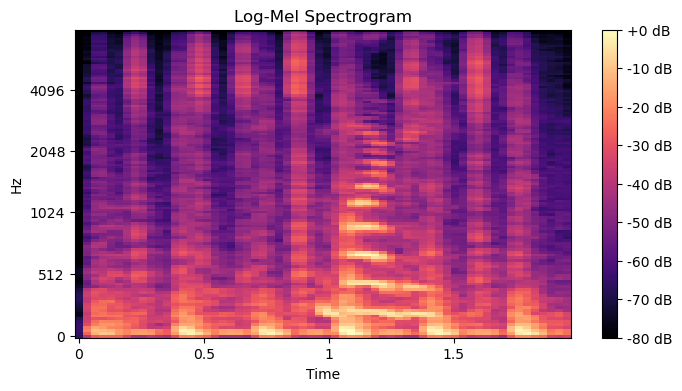

In [7]:
# visualizing log-mel spectrogram
def compute_logmel_spectrogram(y, sr, n_mels=128, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram

# load the audio file
audio_file_path = '../data/barbie_vs_puppy/barbie/barbie_4.wav'
target_sr = 16000

# Load the audio file
y, sr = librosa.load(audio_file_path, sr=target_sr)

# Compute log-mel spectrogram
logmel_spectrogram = compute_logmel_spectrogram(y, sr=sr)

# Display the log-mel spectrogram
plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

In [ ]:
'''
 The resulting log-mel spectrogram provides a compact and informative representation t
 hat is commonly used as input to deep learning models for audio-based tasks
'''